# 02 - Обзор основных алгоритмов Boosting 

In [82]:
if 0:
    !pip install -U xgboost
    !pip install -U lightgbm
    !pip install -U catboost

In [83]:
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# pd.set_option('display.max_columns', None)
%matplotlib inline

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [85]:
DATA_TRAIN = "../data/02/assignment_2_train.csv"
DATA_TEST = "../data/02/assignment_2_test.csv"

In [86]:
data = pd.read_csv(DATA_TRAIN)
print("data.shape = {} rows, {} cols".format(*data.shape))
data.head(n=2)

data.shape = 180000 rows, 394 cols


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 541.1+ MB


In [88]:
ID_F = 'TransactionID'
TARGET_F = 'isFraud'
DT_F = 'TransactionDT'
NUMERICAL_F = data.select_dtypes(include=[np.number]).columns.drop([TARGET_F, ID_F])
CAT_F = data.select_dtypes(include='object').columns

In [89]:
NUMERICAL_F

Index(['TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5',
       'addr1', 'addr2', 'dist1', 'dist2',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=378)

In [90]:
CAT_F

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'],
      dtype='object')

In [10]:
# pd.to_timedelta(tr_data[DT_F], unit='s')

In [91]:
target = data[TARGET_F]
tr_df = data.drop([ID_F, TARGET_F], axis=1)
print("tr_df.shape = {} rows, {} cols".format(*tr_df.shape))

tr_df.shape = 180000 rows, 392 cols


In [92]:
x_train, x_valid = train_test_split(
    tr_df, train_size=0.75, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.75, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 135000 rows, 392 cols
x_valid.shape = 45000 rows, 392 cols


## XGBoost API

In [45]:
import xgboost as xgb

In [46]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 1e-1,
    "n_estimators": 250,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 42,
}
params['gpu_id'] = 1
params['tree_method'] = 'gpu_hist'


In [47]:
dtrain = xgb.DMatrix(
    data=x_train[NUMERICAL_F], label=y_train
)
dvalid = xgb.DMatrix(
    data=x_valid[NUMERICAL_F], label=y_valid
)

In [48]:
%%time
xg_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=10000,
    early_stopping_rounds=50,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=10,
    maximize=True,
)

[00:48:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.64943	valid-auc:0.65410
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[10]	train-auc:0.78824	valid-auc:0.79103
[20]	train-auc:0.83293	valid-auc:0.82837
[30]	train-auc:0.85815	valid-auc:0.85515
[40]	train-auc:0.87440	valid-auc:0.86876
[50]	train-auc:0.88364	valid-auc:0.87536
[60]	train-auc:0.88850	valid-auc:0.87925
[70]	train-auc:0.89283	valid-auc:0.88253
[80]	train-auc:0.89493	valid-auc:0.88412
[90]	train-auc:0.89747	valid-auc:0.88616
[100]	train-auc:0.90021	valid-auc:0.88832
[110]	train-auc:

In [49]:
%%time
cv_result = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=10000,
    early_stopping_rounds=50,
    verbose_eval=10,
    stratified=True,
    metrics="auc",
    maximize=True,
    shuffle=True,
    nfold=5,
)

[00:48:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:48:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:48:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in la

In [18]:
cv_result

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.636216,0.013672,0.630562,0.013131
1,0.652167,0.011655,0.649093,0.014572
2,0.666219,0.011296,0.662462,0.013843
3,0.671948,0.002603,0.670702,0.008604
4,0.672715,0.002470,0.671094,0.008866
...,...,...,...,...
98,0.897982,0.001893,0.891162,0.007271
99,0.898063,0.001961,0.891184,0.007260
100,0.898118,0.002012,0.891238,0.007235
101,0.898145,0.002040,0.891273,0.007219


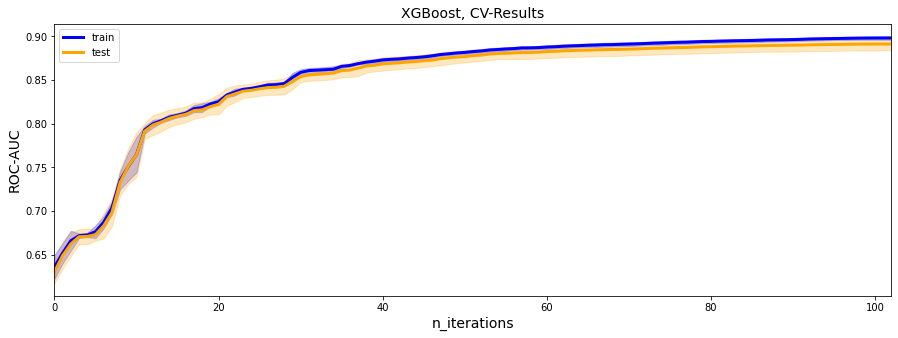

In [19]:
fig = plt.figure(figsize=(15, 5))
plt.plot(cv_result["train-auc-mean"], color="blue", linewidth=3, label="train")
plt.plot(cv_result["test-auc-mean"], color="orange", linewidth=3, label="test")
plt.fill_between(
    x=cv_result.index,
    y1=cv_result["train-auc-mean"] - cv_result["train-auc-std"],
    y2=cv_result["train-auc-mean"] + cv_result["train-auc-std"],
    alpha=0.25, color="blue"
)
plt.fill_between(
    x=cv_result.index,
    y1=cv_result["test-auc-mean"] - cv_result["test-auc-std"],
    y2=cv_result["test-auc-mean"] + cv_result["test-auc-std"],
    alpha=0.25, color="orange"
)
plt.title("XGBoost, CV-Results", size=14)
plt.xlabel("n_iterations", size=14)
plt.xlim(0, cv_result.index.max())
plt.ylabel("ROC-AUC", size=14)
plt.legend(loc="best")

### Обработка категориальных переменных

In [20]:
num_data = data[NUMERICAL_F]

In [50]:
cat_data = data[CAT_F].copy()
CAT_F

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'],
      dtype='object')

In [61]:
#cat_prep = pd.get_dummies(cat_data)

In [62]:
def make_small_cat(col: pd.Series, level: float = 0.05) -> pd.Series:
    """ Заменяет значения признака на other если в отсортированной 
        по возрастанию коммулятивной сумме значение в диапазоне [0, level]
    """
    try:
        vc_p =col.value_counts(normalize=True,ascending=True)
        p_other_cat = vc_p[vc_p.cumsum() <= 0.05].index.to_list()
        return col.apply(lambda x: 'other' if x in p_other_cat else x)
    except Exception as err:
        print(f'Ошибка при обработке {col.name}')
        raise err

In [63]:
cat_data['P_emaildomain'] = make_small_cat(cat_data['P_emaildomain'])
cat_data['R_emaildomain'] = make_small_cat(cat_data['R_emaildomain'])

In [64]:
cat_data['P_emaildomain'].value_counts(normalize=True)

gmail.com        0.443376
yahoo.com        0.191291
hotmail.com      0.099353
anonymous.com    0.087939
aol.com          0.056631
other            0.044345
comcast.net      0.019240
icloud.com       0.011065
outlook.com      0.009792
msn.com          0.009389
att.net          0.008069
sbcglobal.net    0.007205
verizon.net      0.006407
live.com         0.005899
Name: P_emaildomain, dtype: float64

In [65]:
cat_data['R_emaildomain'].value_counts(normalize=True)

gmail.com        0.408690
hotmail.com      0.167977
anonymous.com    0.163881
yahoo.com        0.093964
other            0.044594
aol.com          0.037015
comcast.net      0.019652
outlook.com      0.013665
icloud.com       0.010033
yahoo.com.mx     0.008624
msn.com          0.007927
verizon.net      0.006700
sbcglobal.net    0.006202
live.com         0.005622
cox.net          0.005456
Name: R_emaildomain, dtype: float64

In [66]:
for cat in cat_data:
    print('_'*10 +f'{cat}'+ '_'*10)
    print(cat_data[cat].value_counts())

__________ProductCD__________
W    110340
H     22422
R     21926
C     21664
S      3648
Name: ProductCD, dtype: int64
__________card4__________
visa                118295
mastercard           54501
american express      4818
discover              2378
Name: card4, dtype: int64
__________card6__________
debit              122746
credit              57229
debit or credit        10
charge card             8
Name: card6, dtype: int64
__________P_emaildomain__________
gmail.com        67198
yahoo.com        28992
hotmail.com      15058
anonymous.com    13328
aol.com           8583
other             6721
comcast.net       2916
icloud.com        1677
outlook.com       1484
msn.com           1423
att.net           1223
sbcglobal.net     1092
verizon.net        971
live.com           894
Name: P_emaildomain, dtype: int64
__________R_emaildomain__________
gmail.com        24644
hotmail.com      10129
anonymous.com     9882
yahoo.com         5666
other             2689
aol.com           2232
co

In [67]:
m_dict = {'T': 0, 'F': 1}

In [68]:
m_cols = {'M1','M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9'}

In [69]:
for col in cat_data:
    if col in m_cols:
        print(col)
        cat_data[col] = cat_data[col].apply(m_dict.get)

M1
M2
M3
M5
M6
M7
M8
M9


In [70]:
cat_data['M9'].value_counts()

0.0    26970
1.0     4682
Name: M9, dtype: int64

In [71]:
cat_prep = pd.get_dummies(cat_data)

In [72]:
cat_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Data columns (total 53 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   M1                           61749 non-null   float64
 1   M2                           61749 non-null   float64
 2   M3                           61749 non-null   float64
 3   M5                           61703 non-null   float64
 4   M6                           105652 non-null  float64
 5   M7                           31652 non-null   float64
 6   M8                           31652 non-null   float64
 7   M9                           31652 non-null   float64
 8   ProductCD_C                  180000 non-null  uint8  
 9   ProductCD_H                  180000 non-null  uint8  
 10  ProductCD_R                  180000 non-null  uint8  
 11  ProductCD_S                  180000 non-null  uint8  
 12  ProductCD_W                  180000 non-null  uint8  
 13 

In [73]:
prep_data = num_data.join(cat_prep)

In [74]:
num_data.head()

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
cat_prep.head()

,M1,M2,M3,M5,M6,M7,M8,M9,ProductCD_C,ProductCD_H,...,R_emaildomain_msn.com,R_emaildomain_other,R_emaildomain_outlook.com,R_emaildomain_sbcglobal.net,R_emaildomain_verizon.net,R_emaildomain_yahoo.com,R_emaildomain_yahoo.com.mx,M4_M0,M4_M1,M4_M2
0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,0,1
1,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,0,1,0,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,...,0,0,0,0,0,0,0,0,0,0


In [76]:
data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
prep_data.head()

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,R_emaildomain_msn.com,R_emaildomain_other,R_emaildomain_outlook.com,R_emaildomain_sbcglobal.net,R_emaildomain_verizon.net,R_emaildomain_yahoo.com,R_emaildomain_yahoo.com.mx,M4_M0,M4_M1,M4_M2
0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,NaN,...,0,0,0,0,0,0,0,0,0,1
1,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
2,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,NaN,...,0,0,0,0,0,0,0,1,0,0
3,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
4,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [78]:
x_train, x_valid = train_test_split(
    prep_data, train_size=0.75, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.75, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 135000 rows, 431 cols
x_valid.shape = 45000 rows, 431 cols


In [79]:
dtrain = xgb.DMatrix(
    data=x_train, label=y_train
)
dvalid = xgb.DMatrix(
    data=x_valid, label=y_valid
)

In [80]:
%%time
xg_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=10000,
    early_stopping_rounds=50,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=10,
    maximize=True,
)

[00:52:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.64943	valid-auc:0.65410
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[10]	train-auc:0.78824	valid-auc:0.79103
[20]	train-auc:0.83293	valid-auc:0.82835
[30]	train-auc:0.86387	valid-auc:0.86094
[40]	train-auc:0.87827	valid-auc:0.87243
[50]	train-auc:0.88698	valid-auc:0.87826
[60]	train-auc:0.89521	valid-auc:0.88528
[70]	train-auc:0.90002	valid-auc:0.88938
[80]	train-auc:0.90412	valid-auc:0.89275
[90]	train-auc:0.90672	valid-auc:0.89497
[100]	train-auc:0.90948	valid-auc:0.89729
[110]	train-auc:

In [81]:
%%time
cv_result = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=10000,
    early_stopping_rounds=50,
    verbose_eval=10,
    stratified=True,
    metrics="auc",
    maximize=True,
    shuffle=True,
    nfold=5,
)

[00:53:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:53:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:53:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in la